In [13]:
import pandas as pd

In [14]:
sampled_df = pd.read_csv('../data/imgs/sampled.csv', index_col=0)
if 'lat' in sampled_df.columns and 'lon' in sampled_df.columns:
    sampled_df = sampled_df.drop(columns=['lat', 'lon'])
points_df = pd.read_csv('../data/points.csv')
points_df = points_df.rename(columns={'id': 'orig_id'})
points_df = points_df[['orig_id', 'lat', 'lon']]
city_df = pd.merge(sampled_df, points_df, on=['orig_id'])
city_df.drop(columns=['label'], errors='ignore', inplace=True)
print("Data shape:", city_df.shape)
display(city_df.head())

Data shape: (190693, 9)


,uuid,source,orig_id,city,country,iso3,s2_cell_id,lat,lon
0,99891cd8-bd32-4cc9-9e48-9d7fbdc30909,Mapillary,755195782374799,Washington,United States,USA,9923602171248696735,38.892015,-77.031205
1,0752026e-3449-4e9a-a75b-974e16738eca,Mapillary,3983548141753049,Washington,United States,USA,9923602119460321993,38.903943,-77.018739
2,7e2600a1-eaaf-4d91-8d4d-065984e90cde,Mapillary,233657401861198,Washington,United States,USA,9923602160588049385,38.899477,-77.031631
3,2e92aa72-215d-4672-aa1f-bcd71b02322d,Mapillary,958812788229569,Washington,United States,USA,9923602151766231199,38.902491,-77.029299
4,e9e94c21-5d7b-4f4d-9fb0-42c71745b376,Mapillary,287795916343455,Washington,United States,USA,9923602101490612589,38.893817,-77.015253


In [15]:
# Alternative: Quantile-Based Grid Partitioning for balanced cell counts
def quantile_grid_partition(df: pd.DataFrame, n_lat_bins, n_lon_bins):
    """
    Partition points into a grid using quantiles, ensuring roughly equal counts per cell.
    """
    df = df.copy()
    df['lat_bin'] = pd.qcut(df['lat'], n_lat_bins, labels=False, duplicates='drop')
    df['lon_bin'] = pd.qcut(df['lon'], n_lon_bins, labels=False, duplicates='drop')
    df['label'] = df['lat_bin'] * n_lon_bins + df['lon_bin']
    
    # Renumber labels to be consecutive starting from 0
    unique_labels = df['label'].unique()
    label_map = {old: new for new, old in enumerate(sorted(unique_labels))}
    df['label'] = df['label'].map(label_map)
    
    # Drop temporary columns
    df = df.drop(columns=['lat_bin', 'lon_bin'])
    return df

# Apply quantile-based partitioning (adjust n_lat_bins and n_lon_bins as needed)
city_df = quantile_grid_partition(city_df, n_lat_bins=10, n_lon_bins=10)

# Save to CSV
city_df.to_csv('../data/imgs/sampled.csv')
print(f"Number of unique labels: {city_df['label'].nunique()}")
print(f"Label distribution:\n{city_df['label'].value_counts().describe()}")

Number of unique labels: 100
Label distribution:
count     100.000000
mean     1906.930000
std       690.791206
min        58.000000
25%      1463.250000
50%      1826.000000
75%      2312.250000
max      4835.000000
Name: count, dtype: float64


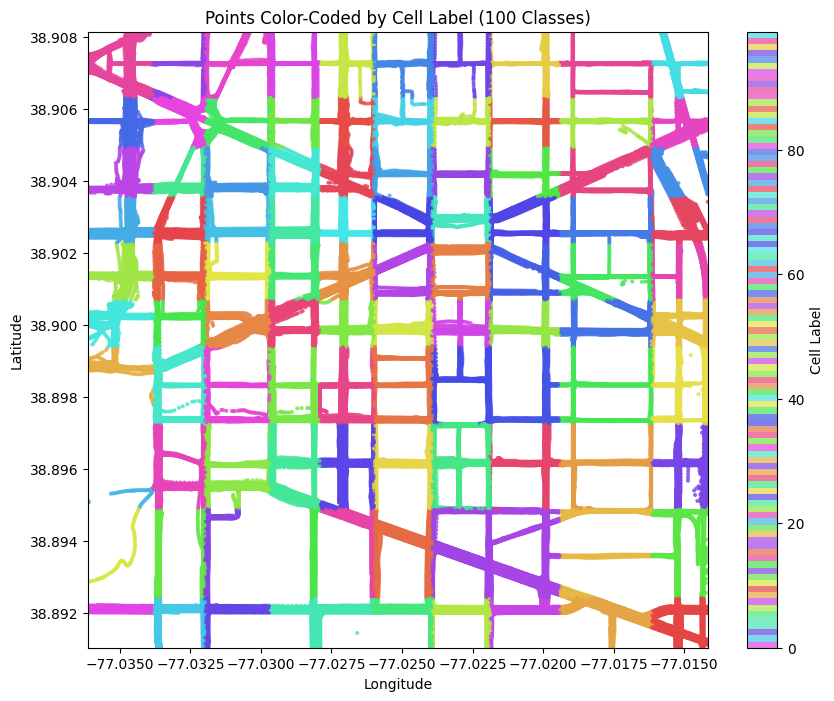

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def scatter_points_by_label(city_df: pd.DataFrame):
    plt.figure(figsize=(10, 8))
    num_labels = city_df['label'].nunique()
    
    # Generate unique colors for each label using HSV color space
    hues = np.linspace(0, 1, num_labels, endpoint=False)
    np.random.seed(42)
    np.random.shuffle(hues)  # Shuffle to avoid similar colors being adjacent
    colors = [mcolors.hsv_to_rgb([h, 0.7, 0.9]) for h in hues]
    cmap = mcolors.ListedColormap(colors)
    
    scatter = plt.scatter(
        city_df['lon'], city_df['lat'],
        c=city_df['label'], cmap=cmap, s=4, alpha=0.7
    )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Points Color-Coded by Cell Label ({num_labels} Classes)')
    plt.xlim(city_df['lon'].min(), city_df['lon'].max())
    plt.ylim(city_df['lat'].min(), city_df['lat'].max())
    plt.colorbar(scatter, label='Cell Label')
    plt.show()

scatter_points_by_label(city_df)

In [17]:
# Output cell IDs ordered by the count of points in each cell
cell_counts = city_df.groupby('label').size().reset_index(name='count')
cell_counts_sorted = cell_counts.sort_values(by='count', ascending=False)
print(cell_counts_sorted)

    label  count
90     90   4835
17     17   3682
89     89   3463
31     31   3193
16     16   3152
..    ...    ...
59     59    873
91     91    781
30     30    770
10     10     73
20     20     58

[100 rows x 2 columns]


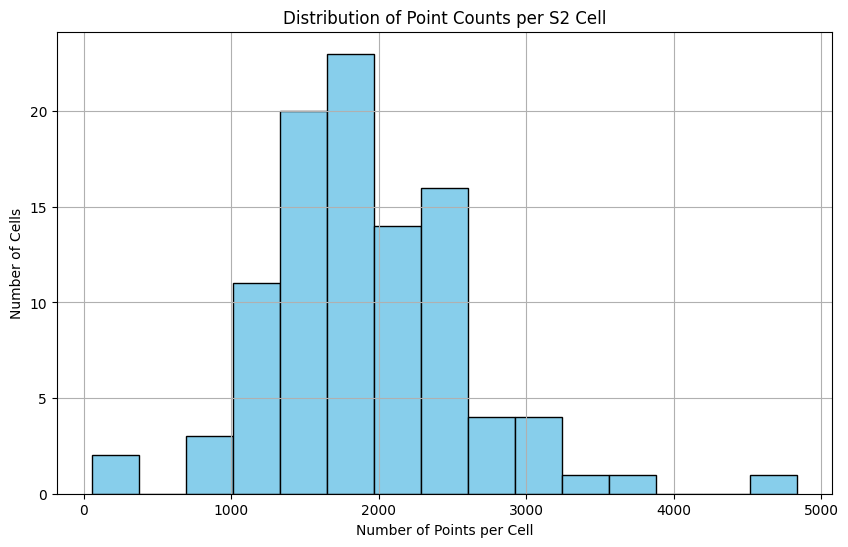

In [18]:
import matplotlib.pyplot as plt

# Plot the distribution of point counts per cell
plt.figure(figsize=(10, 6))
plt.hist(cell_counts_sorted['count'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Number of Points per Cell')
plt.ylabel('Number of Cells')
plt.title('Distribution of Point Counts per S2 Cell')
plt.grid(True)
plt.show()